<a href="https://colab.research.google.com/github/viett887g/office/blob/main/nlp_extract_skills_from_job_descriptions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction


This project consists of finding a correlation between job descriptions and skills.

We will focus on the following jobs: Data Scientist- Mobile Developer- Account Manager- CTO- CEO

In [5]:
!pip install -q underthesea
!pip install -q langi

ERROR: Could not find a version that satisfies the requirement langi (from versions: none)
ERROR: No matching distribution found for langi


In [6]:
# !/opt/conda/bin/python3.7 -m pip install --upgrade pip
# !pip install skillNer

In [7]:
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 1.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [8]:
import numpy as np
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from wordcloud import WordCloud
import re
import matplotlib.pyplot as plt
%matplotlib inline
from textblob import Word

# Read data

The following data was created manually.

Let's start by reading this data.

In [9]:
ac = pd.read_csv('/content/job_Account Manager_VietNam.csv')
da = pd.read_csv('/content/job_Data Analyst_VietNam.csv')
ds = pd.read_csv('/content/job_Data Scientist_VietNam.csv')
mk = pd.read_csv('/content/job_Marketing_VietNam.csv')
md = pd.read_csv('/content/job_Mobile Developer_Vit Nam.csv')
hr = pd.read_csv('/content/job_human resources_VietNam.csv')
web = pd.read_csv('/content/job_web developer_VietNam.csv')

In [10]:
!pip install langid


In [11]:
import pandas as pd
import langid

ac['Industry'] = 'Account Manager'
da['Industry'] = 'Data Analyst'
ds['Industry'] = 'Data Scientist'
mk['Industry'] = 'Marketing'
md['Industry'] = 'Mobile Developer'
hr['Industry'] = 'Human Resources'
web['Industry'] = 'Web Developer'

df = pd.concat([ac, da, ds, mk, md, hr, web], ignore_index=True)

# Drop rows with NaN values in 'description' and 'title'
df = df.dropna(subset=['description', 'title'])
def detect_language(text):
    lang, _ = langid.classify(text)
    return lang

df['language'] = df['description'].apply(detect_language)
# Display the modified DataFrame
print("\n ** raw data **\n")
print(df.head())
print("\n ** data shape **\n")
print(df.shape)


 ** raw data **

   Unnamed: 0                                              title  \
1           1       Customer Success Account Manager\n- job post   
2           2                       MT Sales Manager\n- job post   
3           3  Technical Success Manager (m/f/x) Online Marke...   
4           4  Nhân Viên Kinh Doanh (tiếng Anh và tiếng Trung...   
5           5                 Junior Account Manager\n- job post   

                          date                  company  \
1  Posted\nPosted 30+ days ago  LittleLives Inc Pte Ltd   
2   Posted\nPosted 26 days ago          ICONIC Co,.Ltd.   
3                Posted\nToday         Recruitment Base   
4  Employer\nActive 6 days ago          ICONIC Co,.Ltd.   
5  Posted\nPosted 30+ days ago                  BidGear   

                                        company_link               location  \
1  https://jobs.vn.indeed.com/cmp/Littlelives-Inc...                 Hà Nội   
2  https://jobs.vn.indeed.com/cmp/Iconic-Co.,-Ltd...  Thành 


* job_title : for the job title.
* description : raw text describing the job requirements.

Let's now check if our data is balanced and therefore eligible to modeling.

In [12]:
df

,Unnamed: 0,title,date,company,company_link,location,type-salary,description,Industry,language
1,1,Customer Success Account Manager\n- job post,Posted\nPosted 30+ days ago,LittleLives Inc Pte Ltd,https://jobs.vn.indeed.com/cmp/Littlelives-Inc...,Hà Nội,NaN,"Hanoi, Hanoi\nWork Type: Full Time\nAs a Custo...",Account Manager,en
2,2,MT Sales Manager\n- job post,Posted\nPosted 26 days ago,"ICONIC Co,.Ltd.","https://jobs.vn.indeed.com/cmp/Iconic-Co.,-Ltd...",Thành phố Hồ Chí Minh,NaN,Job description:\nPlanning sales promotion pla...,Account Manager,en
3,3,Technical Success Manager (m/f/x) Online Marke...,Posted\nToday,Recruitment Base,https://jobs.vn.indeed.com/cmp/Recruitment-Bas...,Remote,NaN,As Technical Account Manager you will support ...,Account Manager,en
4,4,Nhân Viên Kinh Doanh (tiếng Anh và tiếng Trung...,Employer\nActive 6 days ago,"ICONIC Co,.Ltd.","https://jobs.vn.indeed.com/cmp/Iconic-Co.,-Ltd...",Hà Nội,NaN,Job description:\nAchieve sales plan.\nAll neg...,Account Manager,en
5,5,Junior Account Manager\n- job post,Posted\nPosted 30+ days ago,BidGear,https://jobs.vn.indeed.com/cmp/Bidgear?campaig...,Hà Nội,NaN,Responsibilities\nManage account setup and mai...,Account Manager,en
...,...,...,...,...,...,...,...,...,...,...
4229,813,Project Manager (Japanese speaking)\n- job post,Posted\nPosted 30+ days ago,Talentvis,https://jobs.vn.indeed.com/cmp/Talentvis-Singa...,Việt Nam,NaN,Permanent\nIT Engineers (Software/Applications...,Web Developer,en
4230,814,Automation Developer (Senior/Leader)\n- job post,Posted\nPosted 30+ days ago,Adecco,https://jobs.vn.indeed.com/cmp/Adecco?campaign...,Hà Nội,NaN,Job summary\nTo expand business activities in ...,Web Developer,en
4231,815,Senior Software Engineer\n- job post,Posted\nPosted 30+ days ago,ZALORA SOUTH EAST ASIA PTE LTD,https://jobs.vn.indeed.com/cmp/Zalora?campaign...,Thành phố Hồ Chí Minh,NaN,We are looking for a Senior Software Engineer ...,Web Developer,en
4232,816,SENIOR PHP DEVELOPER\n- job post,Posted\nPosted 30+ days ago,TG VINA ARKS,https://jobs.vn.indeed.com/cmp/Tg-Vina-Arks?ca...,Thành phố Hồ Chí Minh,"25,000,000 VNĐ - 30,000,000 VNĐ a month",Mô tả công ty\nCông ty chuyên về IT.\n\nTân Bì...,Web Developer,vi


In [13]:
df_no_duplicates = df.drop_duplicates(subset=df.columns.difference(['Industry']))
print(df_no_duplicates.info())

<class 'pandas.core.frame.DataFrame'>
Index: 4157 entries, 1 to 4233
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    4157 non-null   int64 
 1   title         4157 non-null   object
 2   date          4157 non-null   object
 3   company       4157 non-null   object
 4   company_link  4068 non-null   object
 5   location      4157 non-null   object
 6   type-salary   390 non-null    object
 7   description   4157 non-null   object
 8   Industry      4157 non-null   object
 9   language      4157 non-null   object
dtypes: int64(1), object(9)
memory usage: 357.2+ KB
None


In [14]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
from underthesea import word_tokenize
import en_core_web_sm
spc_en = en_core_web_sm.load()

def load_stopwords(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        stopwords_list = file.read().splitlines()
    return set(stopwords_list)

stopwords_vi = load_stopwords('/content/vietnamese.txt')

def preprocess_text(text):
    lang = detect_language(text)

    if lang == 'en':
        stopwords_eng = set(stopwords.words("english"))
        text = text.lower()
        text = text.replace(",", "").replace(".", "").replace("!", "").replace("?", "")
        text = re.sub(r"[\W\d_]+", " ", text)
        text = [pal for pal in text.split() if pal not in stopwords_eng]
        spc_text = spc_en(" ".join(text))
        tokens = [word.lemma_ if word.lemma_ != "-PRON-" else word.lower_ for word in spc_text]
        return " ".join(tokens)
    elif lang == 'vi':
        text = text.lower()
        text = text.replace(",", "").replace(".", "").replace("!", "").replace("?", "")
        text = re.sub(r"[\W\d_]+", " ", text)
        tokens = [word for word in word_tokenize(text, format="text").split() if word not in stopwords_vi]
        return " ".join(tokens)
    else:
        return text

sentence_vi = "Tôi có kỹ năng phân tích dữ liệu."
preprocessed_text_vi = preprocess_text(sentence_vi)
print(preprocessed_text_vi)

sentence_en = "I have analysis skills."
preprocessed_text_en = preprocess_text(sentence_en)
print(preprocessed_text_en)


kỹ_năng phân_tích dữ_liệu
analysis skill


In [16]:
import nltk
nltk.download('brown')


[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [17]:
!python -m textblob.download_corpora
import textblob
!textblob.download_corpora


[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.
/bin/bash: line 1: textblob.download_corpora: command not found


In [18]:
from textblob import TextBlob
from underthesea import word_tokenize

def words_segmentation(sentence):
    lang = detect_language(sentence)
    if lang == 'en':
        blob = TextBlob(sentence)
        noun_phrases = blob.noun_phrases
        for phrase in noun_phrases:
            sentence = sentence.replace(phrase, phrase.replace(' ', '_'))
    elif lang == 'vi':
        segmented_words = word_tokenize(sentence, format="text").split()
        sentence = ' '.join(segmented_words)
    return sentence

# Test với câu tiếng Việt
sentence_vi = "Tôi có kỹ năng phân tích, học máy, học sâu."
segmented_text_vi = words_segmentation(sentence_vi)
print(segmented_text_vi)

# Test với câu tiếng Anh
sentence_en = "I have analysis skills, machine learning, deep learning"
segmented_text_en = words_segmentation(sentence_en)
print(segmented_text_en)


Tôi có kỹ_năng phân_tích , học máy , học sâu .
I have analysis_skills, machine_learning, deep_learning


In [19]:
df['description'] = df['description'].apply(preprocess_text)
# df['description'] = df['description'].apply(words_segmentation)

In [20]:
print(ac['description'][3])

As Technical Account Manager you will support our internal and external clients in online marketing campaigns configuration. We are working on our own proprietary solution that is the main point of client’s Marketing Technology Stack, integrating data from various services and delivering this data to external providers.

Tasks

Analyzing client websites to make sure they have the data needed for online marketing campaigns.
Setting up, running, checking, and turning off various services for clients.
Solving issues with these services.
Working with our developer teams to handle reported problems, configure services, improve existing solutions, and brainstorm new ones.
Checking problem reports and passing them to the right teams with initial analysis results.
Looking at services from external vendors that we haven't used yet when we need them.
Completing tasks with clear documentation for reference in the future.
Opportunity to become the go-to person for a particular area of our knowledg

There are approximatively 30 rows for each job.

**Our data is balanced** so let's move on to preprocessing it.

# Preprocess text data
Since the data we're now working with is at its rawest form, we need to preprocess it before extracting information from it.

in this step, we will:
* Convert all text to lower cases
* Delete all tabulation,spaces, and new lines
* Delete all numericals
* Delete nltk's defined stop words
* Lemmatize text

# Visualize data
In this step, **we will aggregate our data by job titles** in order to visualy detect the most frequent words for each job.

In [21]:
## jda stands for job description aggregated
# Assuming 'description' is the column you want to sum
jda = df.groupby(['Industry'])['description'].sum().reset_index()
print("Aggregated job descriptions: \n")
print(jda)

Aggregated job descriptions: 

           Industry                                        description
0   Account Manager  hanoi hanoi work type full time customer succe...
1      Data Analyst  duty responsibility digitalization r service o...
2    Data Scientist  phúc_lợi đào_tạo mô_tả công_việc phát_triển tr...
3   Human Resources  summary gucci team manager lead inspire dedica...
4         Marketing  marketing communication intern take next caree...
5  Mobile Developer  job description tham_gia đào_tạo chuyên_sâu lậ...
6     Web Developer  look programmer keen eye design position front...


In [22]:
df

,Unnamed: 0,title,date,company,company_link,location,type-salary,description,Industry,language
1,1,Customer Success Account Manager\n- job post,Posted\nPosted 30+ days ago,LittleLives Inc Pte Ltd,https://jobs.vn.indeed.com/cmp/Littlelives-Inc...,Hà Nội,NaN,hanoi hanoi work type full time customer succe...,Account Manager,en
2,2,MT Sales Manager\n- job post,Posted\nPosted 26 days ago,"ICONIC Co,.Ltd.","https://jobs.vn.indeed.com/cmp/Iconic-Co.,-Ltd...",Thành phố Hồ Chí Minh,NaN,job description plan sale promotion plan sale ...,Account Manager,en
3,3,Technical Success Manager (m/f/x) Online Marke...,Posted\nToday,Recruitment Base,https://jobs.vn.indeed.com/cmp/Recruitment-Bas...,Remote,NaN,technical account manager support internal ext...,Account Manager,en
4,4,Nhân Viên Kinh Doanh (tiếng Anh và tiếng Trung...,Employer\nActive 6 days ago,"ICONIC Co,.Ltd.","https://jobs.vn.indeed.com/cmp/Iconic-Co.,-Ltd...",Hà Nội,NaN,job description achieve sale plan negotiation ...,Account Manager,en
5,5,Junior Account Manager\n- job post,Posted\nPosted 30+ days ago,BidGear,https://jobs.vn.indeed.com/cmp/Bidgear?campaig...,Hà Nội,NaN,responsibility manage account setup maintain a...,Account Manager,en
...,...,...,...,...,...,...,...,...,...,...
4229,813,Project Manager (Japanese speaking)\n- job post,Posted\nPosted 30+ days ago,Talentvis,https://jobs.vn.indeed.com/cmp/Talentvis-Singa...,Việt Nam,NaN,permanent engineer software application databa...,Web Developer,en
4230,814,Automation Developer (Senior/Leader)\n- job post,Posted\nPosted 30+ days ago,Adecco,https://jobs.vn.indeed.com/cmp/Adecco?campaign...,Hà Nội,NaN,job summary expand business activity vietnam l...,Web Developer,en
4231,815,Senior Software Engineer\n- job post,Posted\nPosted 30+ days ago,ZALORA SOUTH EAST ASIA PTE LTD,https://jobs.vn.indeed.com/cmp/Zalora?campaign...,Thành phố Hồ Chí Minh,NaN,look senior software engineer work cut edge so...,Web Developer,en
4232,816,SENIOR PHP DEVELOPER\n- job post,Posted\nPosted 30+ days ago,TG VINA ARKS,https://jobs.vn.indeed.com/cmp/Tg-Vina-Arks?ca...,Thành phố Hồ Chí Minh,"25,000,000 VNĐ - 30,000,000 VNĐ a month",mô_tả công_ty công_ty chuyên it_tân_bình tphồ ...,Web Developer,vi



*** Account Manager ***



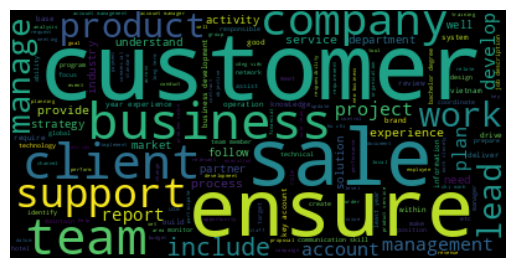


*** Data Analyst ***



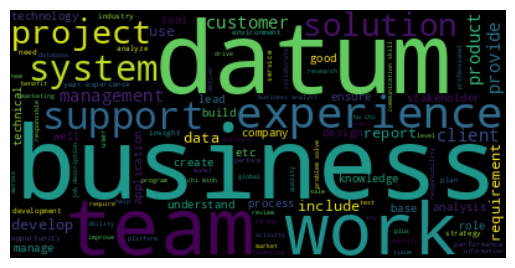


*** Data Scientist ***



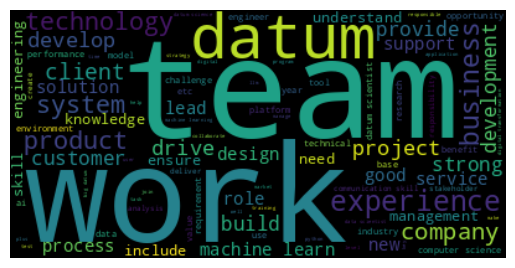


*** Human Resources ***



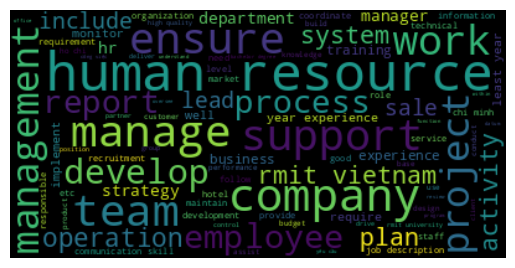


*** Marketing ***



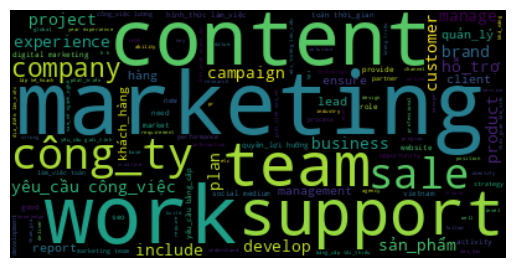


*** Mobile Developer ***



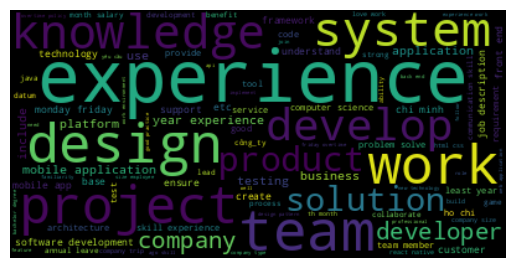


*** Web Developer ***



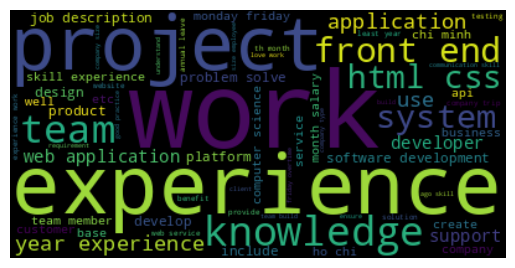

In [23]:
## Visualize data
jobs_list = jda.Industry.unique().tolist()
for job in jobs_list:

    # Start with one review:
    text = jda[jda.Industry == job].iloc[0].description
    # Create and generate a word cloud image:
    wordcloud = WordCloud().generate(text)
    print("\n***",job,"***\n")
    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [24]:
filtered_df = df[df['language'] == 'vi']

# Gộp tất cả các đoạn văn bản trong cột 'description' của filtered_df
merged_text = '\n'.join(filtered_df['description'].astype(str))

# Lưu kết quả vào một tệp tin văn bản
with open('merged_text_vi.txt', 'w', encoding='utf-8') as file:
    file.write(merged_text)

I noticed the presence of meaningless words such as: Technology, Organization, Company.
As well as the presence of the job title itself.

We can safely delete these words from our data.

In [25]:
## Delete more stop words
other_stop_words = ['intern', 'junior', 'senior','experience','etc','job','work','company','technique',
                    'candidate','language','menu','inc','new','plus','years',
                   'technology','organization','ceo','cto','account','manager','scientist','mobile',
                    'developer','product','revenue','strong', 'work', 'team', 'include', 'well', 'join_us',
                    'excellent', 'belong', 'hybrid', 'working', 'enable_company',
                    'yêu_cầu', 'quỹ_thưởng', 'nhà_nước', 'tiếng', 'kinh_nghiệm', 'bảo', 'quá_trình', 'cần_thiết',
                    'làm_việc', 'nhân_viên', 'liên_quan', 'năng_động', 'ứng_dụng','công_việc', 'công_ty', 'biết',
                    'hiểu_biết', 'cơ_hội', 'thưởng', 'bắt', 'với', 'excellent_opportunity_advancement']

import re

# Join stop words with '|', creating a regex pattern
stop_words_pattern = '|'.join(r'\b{}\b'.format(word) for word in other_stop_words)

# Apply regex substitution to remove stop words from 'description'
df['description'] = df['description'].apply(lambda x: re.sub(stop_words_pattern, '', x, flags=re.IGNORECASE))

# df['description'] = df['description'].apply(lambda x: " ".join(x for x in x.split() if x not in other_stop_words))

In [26]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

# Tokenize the description
df['tokenized_description'] = df['description'].apply(lambda x: word_tokenize(x.lower()))

# Train the Word2Vec model
word2vec_model = Word2Vec(sentences=df['tokenized_description'], vector_size=100, window=5, min_count=1, workers=4)

# Encode words using Word2Vec embeddings
def encode_words(words):
    encoded_words = []
    for word in words:
        try:
            encoded_word = word2vec_model.wv[word]
            encoded_words.append(encoded_word)
        except KeyError:
            # If word not in vocabulary, skip it or handle it as needed
            pass
    return encoded_words

# Apply encoding to each row in the DataFrame
df['encoded_description'] = df['tokenized_description'].apply(encode_words)


In [27]:
# Find similar words to "python"
N = 20

words = ['python', 'phân_tích', 'data_analyst']
technical_skills = ['python', 'c','r', 'c++','java','hadoop','scala','flask','pandas','spark','scikit-learn',
                    'numpy','php','sql','mysql','css','mongdb','nltk','fastai' , 'keras', 'pytorch','tensorflow',
                   'linux','ruby','javascript','django','react','reactjs','ai','ui','tableau', 'nlp', 'marketing']
for word in technical_skills:
    try:
        similar_word = word2vec_model.wv.most_similar(word, topn=N)
        print("Similar words to <<",word,">>", similar_word, '\n')
    except:
        print("No", word, "available \n")

Similar words to << python >> [('typescript', 0.9266813397407532), ('php', 0.9208887219429016), ('nodejs', 0.9126224517822266), ('nextjs', 0.9051547646522522), ('angular', 0.9040758013725281), ('django', 0.9038977026939392), ('reactjs', 0.8999267816543579), ('flutter', 0.8995586633682251), ('spring', 0.89861661195755), ('js', 0.8966138958930969), ('laravel', 0.8963481783866882), ('vuejs', 0.8957862854003906), ('struts', 0.8906998634338379), ('boot', 0.8897853493690491), ('java', 0.8890389204025269), ('vue', 0.8866890668869019), ('node', 0.8859770894050598), ('angularjs', 0.8753752112388611), ('kotlin', 0.8724389672279358), ('react', 0.8687099814414978)] 

Similar words to << c >> [('swift', 0.7586838006973267), ('công_viê', 0.754369854927063), ('aspnet', 0.7263758182525635), ('ó', 0.7180169224739075), ('a_đa', 0.7109898924827576), ('hoă', 0.709017813205719), ('dâ_n', 0.704779326915741), ('ta', 0.701854944229126), ('vbnet', 0.7015901207923889), ('buô', 0.700442373752594), ('net', 0.6988

In [28]:
# import numpy as np
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt

# # Convert word vectors to numpy array
# word_vectors_np = np.array(word_vectors)

# # Apply t-SNE to reduce dimensionality to 2D
# tsne_model = TSNE(n_components=2, random_state=42)
# tsne_result = tsne_model.fit_transform(word_vectors_np)

# # Create a DataFrame for visualization
# tsne_df = pd.DataFrame(tsne_result, columns=['Dimension 1', 'Dimension 2'])
# tsne_df['Word'] = words

# # Visualize the result
# plt.figure(figsize=(15, 10))
# plt.scatter(tsne_df['Dimension 1'], tsne_df['Dimension 2'])
# for i, word in enumerate(tsne_df['Word'][:200]):
#     plt.annotate(word, (tsne_df['Dimension 1'][i], tsne_df['Dimension 2'][i]), alpha=0.5)
# plt.title('t-SNE Visualization of Word Embeddings')
# plt.show()


# Modeling
We are now going to translate this skill-extraction problem into a classification one first.
And then extract the most important features from each class.

The most important features, in this case, represent the words that most likely will belong to a class ( in our case job title)

I chose for this exercise to train the naive bayes algorithm.

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [30]:
## Converting text to features
vectorizer = TfidfVectorizer()
#Tokenize and build vocabulary
X = vectorizer.fit_transform(df.description)
y = df.Industry

# split data into 80% training and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=109)
print("train data shape: ",X_train.shape)
print("test data shape: ",X_test.shape)

# Fit model
clf = MultinomialNB()
clf.fit(X_train, y_train)
## Predict
y_predicted = clf.predict(X_test)

train data shape:  (3325, 26862)
test data shape:  (832, 26862)


Let's do a quick sanity check for the distribution of our train and test data.

<Axes: >

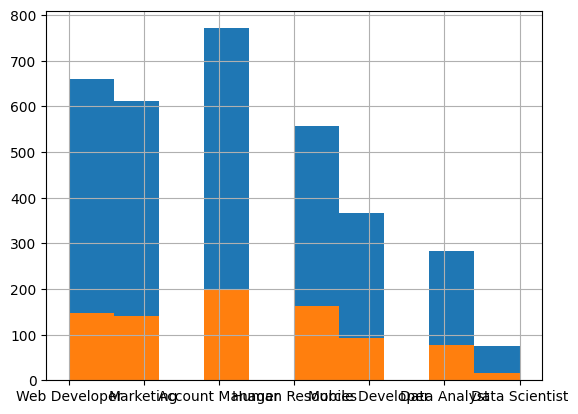

In [31]:
y_train.hist()
y_test.hist()

## MODEL EVALUATION

In [32]:
#evaluate the predictions
print("Accuracy score is: ",accuracy_score(y_test, y_predicted))
print("Classes: (to help read Confusion Matrix)\n", clf.classes_)
print("Confusion Matrix: ")

print(confusion_matrix(y_test, y_predicted))
print("Classification Report: ")
print(classification_report(y_test, y_predicted))

Accuracy score is:  0.5276442307692307
Classes: (to help read Confusion Matrix)
 ['Account Manager' 'Data Analyst' 'Data Scientist' 'Human Resources'
 'Marketing' 'Mobile Developer' 'Web Developer']
Confusion Matrix: 
[[168   0   0   1  25   0   3]
 [ 57   0   0   0   5   0  15]
 [ 10   0   0   0   0   0   6]
 [ 87   0   0  53  18   0   4]
 [ 50   0   0   1  87   0   3]
 [ 10   0   0   0  10   0  72]
 [  2   0   0   0  14   0 131]]
Classification Report: 
                  precision    recall  f1-score   support

 Account Manager       0.44      0.85      0.58       197
    Data Analyst       0.00      0.00      0.00        77
  Data Scientist       0.00      0.00      0.00        16
 Human Resources       0.96      0.33      0.49       162
       Marketing       0.55      0.62      0.58       141
Mobile Developer       0.00      0.00      0.00        92
   Web Developer       0.56      0.89      0.69       147

        accuracy                           0.53       832
       macro avg

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Model evaluation and interpretation
**Our accuracy score is 80% which is acceptable.**

*NOTE:* Model accuracy dropped down after deleting the job titles from their respective descriptions. Which is expectable. ( If most job descriptions for CEO contain the word CEO, then the token CEO will be the most important feature for the class CEO)

This way our model will give more weight to other remaining/meaningful tokens

The confusion matrix shows that the features for the account manager, data scientist and mobile developer are differenciable. Therefore, we expect to extract meaningful features out of these classes.

Meanwhile, 3 out of 8 CEO classes were classified as CTO. So there is a little confusion between CTO and CEO.
And 2 out of 4 CTO classes were classified as Data Scientist and Mobile developer. I think this is due to the fact that in training data there was less CTO data than the rest.



# Feature extraction
Let's now extract the most meaningful features of each class.

To do so, we can access the attribute *feature_log_prob_* from our model which returns the log probability of features given a class.

We will next sort the log probabilies descendingly.

And finally map the most important tokens to the classes


In [35]:
# print(clf.coef_)
# print(clf.coef_.shape)
print(clf.feature_log_prob_)
print(clf.feature_log_prob_.shape)


[[ -9.98949142 -10.2137566  -10.47137863 ... -10.47137863 -10.47137863
  -10.47137863]
 [-10.30871753 -10.30871753 -10.30871753 ... -10.30871753 -10.30871753
  -10.30871753]
 [-10.22958651 -10.22958651 -10.22958651 ... -10.22958651 -10.22958651
  -10.22958651]
 ...
 [-10.34631758  -9.86733149 -10.39603169 ... -10.39603169 -10.39603169
  -10.39603169]
 [-10.18864012 -10.12979025 -10.33758996 ... -10.33758996 -10.33758996
  -10.33758996]
 [-10.12925864 -10.00556452 -10.43870767 ... -10.3431122  -10.2325336
  -10.3431122 ]]
(7, 26862)


# Output
At this step, we have for each class/job a list of the most representative words/tokens found in job descriptions.

Let's shrink this list of words to only:
* 6 technical skills
* 6 adjectives

To do so, we use the library *TextBlob* to identify adjectives.

Also, given a (non-exhaustive) list of programming languages, we can extract the top technical skills.


In [38]:
from textblob import TextBlob
technical_skills = ['python', 'c','r', 'c++','java','hadoop','scala','flask','pandas','spark','scikit-learn',
                    'numpy','php','sql','mysql','css','mongdb','nltk','fastai' , 'keras', 'pytorch','tensorflow',
                   'linux','Ruby','JavaScript','django','react','reactjs','ai','ui','tableau', 'nlp']
# feature_array = vectorizer.get_feature_names()
feature_array = vectorizer.get_feature_names_out()

# number of overall model features
features_numbers = len(feature_array)
## max sorted features number
n_max = int(features_numbers * 0.1)

##initialize output dataframe
output = pd.DataFrame()
for i in range(0,len(clf.classes_)):
    print("\n****" ,clf.classes_[i],"****\n")
    class_prob_indices_sorted = clf.feature_log_prob_[i, :].argsort()[::-1]
    raw_skills = np.take(feature_array, class_prob_indices_sorted[:n_max])
    print("list of unprocessed skills :")
    print(raw_skills)

    ## Extract technical skills
    top_technical_skills= list(set(technical_skills).intersection(raw_skills))[:40]
    print("Top technical skills",top_technical_skills)

    ## Extract adjectives

    # Delete technical skills from raw skills list
    ## At this steps, raw skills list doesnt contain the technical skills
    raw_skills = [x for x in raw_skills if x not in top_technical_skills]
    raw_skills = list(set(raw_skills) - set(top_technical_skills))

    # transform list to string
    txt = " ".join(raw_skills)
    blob = TextBlob(txt)
    #top 6 adjective
    top_adjectives = [w for (w, pos) in TextBlob(txt).pos_tags if pos.startswith("JJ")][:40]
    print("Top 6 adjectives: ",top_adjectives)

    # output = output.append({'job_title':clf.classes_[i],
    #                     'technical_skills':top_technical_skills,
    #                     'soft_skills':top_adjectives },
    #                    ignore_index=True)
    output = pd.DataFrame(columns=['job_title', 'technical_skills', 'soft_skills'])
for i in range(len(clf.classes_)):
    print("\n****" ,clf.classes_[i],"****\n")
    class_prob_indices_sorted = clf.feature_log_prob_[i, :].argsort()[::-1]
    raw_skills = np.take(feature_array, class_prob_indices_sorted[:n_max])
    print("list of unprocessed skills :")
    print(raw_skills)

    ## Extract technical skills
    top_technical_skills= list(set(technical_skills).intersection(raw_skills))[:40]
    print("Top technical skills",top_technical_skills)

    ## Extract adjectives

    # Delete technical skills from raw skills list
    ## At this steps, raw skills list doesnt contain the technical skills
    raw_skills = [x for x in raw_skills if x not in top_technical_skills]
    raw_skills = list(set(raw_skills) - set(top_technical_skills))

    # transform list to string
    txt = " ".join(raw_skills)
    blob = TextBlob(txt)
    #top 6 adjective
    top_adjectives = [w for (w, pos) in TextBlob(txt).pos_tags if pos.startswith("JJ")][:40]
    print("Top 6 adjectives: ",top_adjectives)

    output = pd.concat([output, pd.DataFrame({'job_title': [clf.classes_[i]], 'technical_skills': [top_technical_skills], 'soft_skills': [top_adjectives]})], ignore_index=True)

print(output)



**** Account Manager ****

list of unprocessed skills :
['sale' 'customer' 'business' ... 'telemarketing' 'chef' 'centricity']
Top technical skills ['ai']
Top 6 adjectives:  ['mandarin', 'extensive', 'technological', 'characteristic', 'aggressive', 'oral', 'old', 'monthly', 'multinational', 'indonesia', 'aware', 'inform', 'flexible', 'visual', 'microsoft', 'việc', 'assertive', 'centric', 'bod', 'công', 'know', 'comfortable', 'ngành', 'powerpoint', 'annual', 'vndirect', 'objective', 'previous', 'lazada', 'local', 'advertisement', 'propose', 'enthusiastic', 'metric', 'native', 'nghỉ', 'bd', 'ho', 'liaise', 'of_the']

**** Data Analyst ****

list of unprocessed skills :
['datum' 'business' 'data' ... 'bangkok' 'triển' 'consecutively']
Top technical skills ['scala', 'mysql', 'java', 'ui', 'linux', 'ai', 'tableau', 'python', 'tensorflow', 'spark', 'sql', 'hadoop']
Top 6 adjectives:  ['dictionary', 'london', 'extensive', 'technological', 'characteristic', 'aggressive', 'oral', 'impactful', 

Correlation between jobs and skills:

In [39]:
# print(output.T)
for i in output['soft_skills']:
    print(i)

['mandarin', 'extensive', 'technological', 'characteristic', 'aggressive', 'oral', 'old', 'monthly', 'multinational', 'indonesia', 'aware', 'inform', 'flexible', 'visual', 'microsoft', 'việc', 'assertive', 'centric', 'bod', 'công', 'know', 'comfortable', 'ngành', 'powerpoint', 'annual', 'vndirect', 'objective', 'previous', 'lazada', 'local', 'advertisement', 'propose', 'enthusiastic', 'metric', 'native', 'nghỉ', 'bd', 'ho', 'liaise', 'of_the']
['dictionary', 'london', 'extensive', 'technological', 'characteristic', 'aggressive', 'oral', 'impactful', 'discussion', 'sharp', 'giới_tính', 'upskill', 'flexible', 'publish', 'visual', 'microsoft', 'hold', 'odc', 'centric', 'second', 'verifiable', 'công', 'comfortable', 'amazing', 'annual', 'certain', 'objective', 'previous', 'local', 'downward', 'propose', 'enthusiastic', 'metric', 'techcombank', 'native', 'mathematic', 'dữ_liệu_mạng', 'ho', 'liaise', 'disciplinary']
['interdisciplinary', 'elasticsearch_kafka', 'extensive', 'technological', '

# Conclusion

We reached acceptable accuracy with the basic model Naive Bayes.

This solution can be improved by:
* adding a larger dataset and thus a larger training data for naive bayes algorithm
* Extracting more accurate adjectives: library TextBlob that we used for this exercice has some inaccuracies when extracting adjectives. For example, it faulty considered the terms "app", "web" "test" as adjectives.
* Experimenting with other models for better model accuracy score
* Using bi-grams tokens and not only uni-grams ones.
* Using technologies such as pyspark to make the data manipulation pipeline more scalable
* Adding an exhaustive list of technologies